In [25]:
import pandas as pd
import numpy as np

In [26]:
df = pd.read_csv("powerplant_data.csv")

In [27]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


###### AT => Temperature
###### V => Vaccume
###### AP => Pressure
###### PH => Humidity
###### PE => Produced Energy

In [28]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [29]:
X = df.drop("PE", axis=1)
y = df["PE"]

In [30]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [31]:
y.head()

0    480.48
1    445.75
2    438.76
3    453.09
4    464.43
Name: PE, dtype: float64

In [32]:
# Split out data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
df.shape

(9568, 5)

### scaled data

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Tensor Creation

In [35]:
import torch
import torch.nn as nn

In [36]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

In [37]:
type(X_train_scaled)

numpy.ndarray

In [38]:
type(y_train)

pandas.Series

In [39]:
y_train.shape

(7654,)

In [40]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [41]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32) 

# Deep Learning

In [42]:
# Build our ANN Model:

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        self.model = nn.Sequential(
            # 1st hidden layer
            nn.Linear(X_train.shape[1], 6),
            nn.ReLU(),

            # 2nd Hidden Layer
            nn.Linear(6, 6),
            nn.ReLU(),

            # Output Layer
            nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.model(x)

In [43]:
import torch.optim as optim

model = ANN()

# loss, optimizer
crietrian = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [44]:
# Train the ANN

train_losses = []
val_losses = []

best_val_loss = float("inf")

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0; # total training loss for 1 epoch

    for xb, yb in train_loader:
        # xb = features of 1 batch -> inputs
        # yb = lables of 1 batch -> outputs
        optimizer.zero_grad()

        outputs = model(xb) # forward prop... predicted outputs for this batch
        loss = crietrian(outputs, yb) # compute loss
        loss.backward() # back prop... compute gradients
        optimizer.step() # parameters update

        running_loss += loss.item() # loss is a tensor -> py float

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # validation
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad(): # no gradients compute
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = crietrian(outputs, yb)
            running_val_loss += loss

    epoch_val_loss = running_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"epoch {epoch+1}/{epochs} ==> train loss = {epoch_train_loss} & val loss = {epoch_val_loss}")
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pt") # .pt or .pth

epoch 1/100 ==> train loss = 204908.16770833332 & val loss = 201354.03125
epoch 2/100 ==> train loss = 188269.32571614583 & val loss = 167605.078125
epoch 3/100 ==> train loss = 135280.68590494792 & val loss = 102743.140625
epoch 4/100 ==> train loss = 76205.92506510417 & val loss = 56237.8359375
epoch 5/100 ==> train loss = 42639.42587076823 & val loss = 31808.73046875
epoch 6/100 ==> train loss = 23777.56619466146 & val loss = 17673.8359375
epoch 7/100 ==> train loss = 14015.004307047526 & val loss = 11168.171875
epoch 8/100 ==> train loss = 9433.8044921875 & val loss = 7634.1669921875
epoch 9/100 ==> train loss = 6430.756705729166 & val loss = 5097.244140625
epoch 10/100 ==> train loss = 4288.903333536784 & val loss = 3347.993896484375
epoch 11/100 ==> train loss = 2809.6843065897624 & val loss = 2260.50341796875
epoch 12/100 ==> train loss = 1951.59306640625 & val loss = 1637.601806640625
epoch 13/100 ==> train loss = 1424.5304472605387 & val loss = 1241.8492431640625
epoch 14/100 

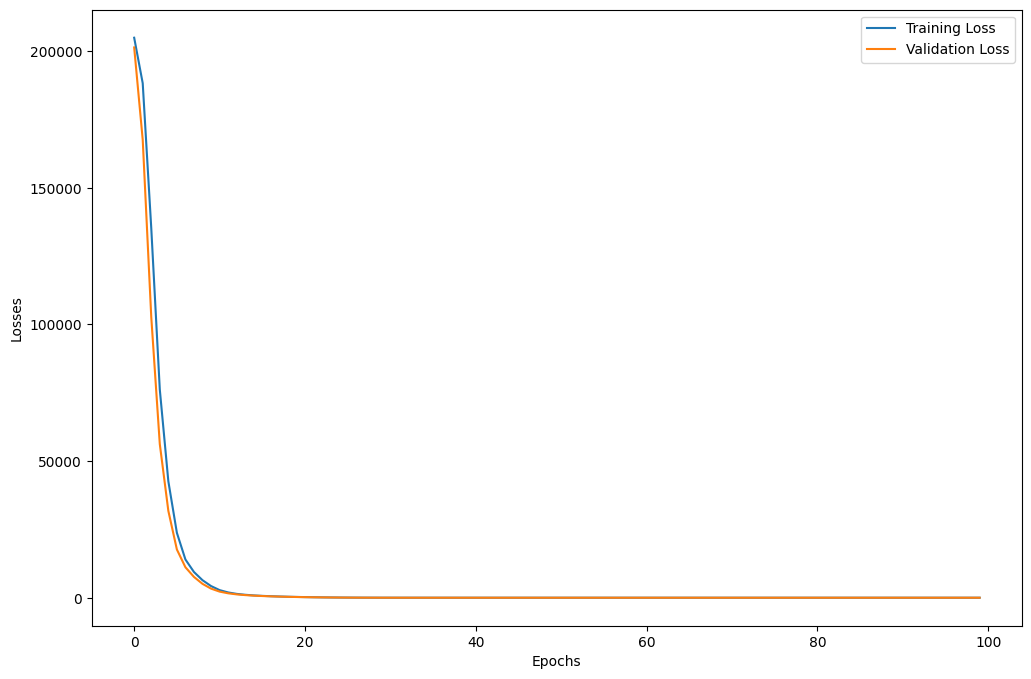

In [45]:
import matplotlib.pyplot as plt

loss_df = pd.DataFrame({
    "Training Loss": train_losses,
    "Validataion Loss": val_losses
})

plt.figure(figsize=(12,8))
plt.plot(loss_df["Training Loss"], label="Training Loss")
plt.plot(loss_df["Validataion Loss"], label="Validation Loss")

plt.xlabel("Epochs");
plt.ylabel("Losses");
plt.legend()

# Loading and saving best model

###### with each epoch there are different learnable parameters (w-> weights, b-> bias)
###### best model is the one having loss should be minimal 
###### there are basically two different parameters -> training & validation 
###### we have to minimize the validation loss because it is being calculated on untrained data sets

###### So, set the parameters with having validation loss as minimal

In [46]:
# Loading the best model 

model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [47]:
# Evaluation

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    train_mse_loss = crietrian(train_preds, y_train_tensor);

with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_mse_loss = crietrian(test_preds, y_test_tensor);

print("Training MSE: ", train_mse_loss.item())
print("Test MSE: ", test_mse_loss.item())

Training MSE:  21.21486473083496
Test MSE:  19.55294418334961


In [48]:
from sklearn.metrics import r2_score

print("r2_score =", r2_score(y_test, test_preds))

r2_score = 0.9316675058545187


In [49]:
predicted_df = pd.DataFrame(test_preds.numpy(), columns=["Predicted Values"])
actual_df = pd.DataFrame(y_test.values, columns=["Actual Values"])

pd.concat([predicted_df, actual_df], axis=1)

,Predicted Values,Actual Values
0,435.430908,433.27
1,437.203827,438.16
2,461.486969,458.42
3,476.227570,480.82
4,435.937531,441.41
...,...,...
1909,451.220184,456.70
1910,431.920013,438.04
1911,467.357208,467.80
1912,431.435333,437.14
